# NASA Turbofan Jet Engine - EDA (Exploratory Data Analysis)

## 프로젝트 개요
- **목표**: NASA 터보팬 제트 엔진의 잔존 수명(RUL) 예측 및 예지보전 방안 모색
- **데이터**: NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) 데이터셋

## EDA 구조
1. 데이터 불러오기
2. 전체 사이클 분포 분석
3. 센서별 드리프트/패턴 분석
4. 제거할 센서 리스트 확정
5. Rolling window 길이 확정

## 1. 라이브러리 Import 및 초기 설정

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
import pandas as pd
from pathlib import Path

raw_path = Path('../CMaps/train_FD004.txt')
save_path = Path('../CMaps/Data/train_FD004.csv')

column_names = [
    'unit_id', 'time_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

df = pd.read_csv(raw_path, sep='\s+', header=None, names=column_names)
df.to_csv(save_path, index=False)



In [3]:

raw_path = Path('../CMaps/test_FD004.txt')
save_path = Path('../CMaps/Data/test_FD004.csv')

column_names = [
    'unit_id', 'time_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]


df = pd.read_csv(raw_path, sep='\s+', header=None, names=column_names)
df.to_csv(save_path, index=False)

## 2. 데이터 불러오기

데이터 구조:
- **26개 컬럼**: unit number(1) + time(1) + operational settings(3) + sensor measurements(21)
- **FD004**: 248개 train, 249개 test (조건: 6개, 고장모드: HPC + Fan Degradation)

In [7]:
# 데이터 경로 설정
data_path = Path('../CMaps/Data')

train_df = pd.read_csv(data_path / 'train_FD004.csv')
test_df = pd.read_csv(data_path / 'test_FD004.csv') 

## FD004 환경 조건 변수 분포 및 해석
- **op1(고도)**: 다중 이산 값 (0, 10, 20, ...), 연속적이 아닌 단계별 구간, 예: 10 → 10,000 피트 고도
- **op2(마하)**: 다중 이산 값 (0.0, 0.25, 0.6, 0.8 등), 단계별 구간
- **op3(스로틀)**: 이진 값 (60, 100), 단 2가지 추력 조건, 이진 특성 뚜렷함
- FD004는 복합 운전 조건으로, 환경 변수의 분포가 FD001과 달리 여러 구간/이진 특성을 가짐

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61249 entries, 0 to 61248
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_id       61249 non-null  int64  
 1   time_cycles   61249 non-null  int64  
 2   op_setting_1  61249 non-null  float64
 3   op_setting_2  61249 non-null  float64
 4   op_setting_3  61249 non-null  float64
 5   T2            61249 non-null  float64
 6   T24           61249 non-null  float64
 7   T30           61249 non-null  float64
 8   T50           61249 non-null  float64
 9   P2            61249 non-null  float64
 10  P15           61249 non-null  float64
 11  P30           61249 non-null  float64
 12  Nf            61249 non-null  float64
 13  Nc            61249 non-null  float64
 14  epr           61249 non-null  float64
 15  Ps30          61249 non-null  float64
 16  phi           61249 non-null  float64
 17  NRf           61249 non-null  float64
 18  NRc           61249 non-nu

In [9]:
train_df.head()

unit_id  time_cycles  op_setting_1  op_setting_2  op_setting_3      T2  \
0        1            1       42.0049        0.8400         100.0  445.00   
1        1            2       20.0020        0.7002         100.0  491.19   
2        1            3       42.0038        0.8409         100.0  445.00   
3        1            4       42.0000        0.8400         100.0  445.00   
4        1            5       25.0063        0.6207          60.0  462.54   

      T24      T30      T50    P2  ...     phi      NRf      NRc      BPR  \
0  549.68  1343.43  1112.93  3.91  ...  129.78  2387.99  8074.83   9.3335   
1  606.07  1477.61  1237.50  9.35  ...  312.59  2387.73  8046.13   9.1913   
2  548.95  1343.12  1117.05  3.91  ...  129.62  2387.97  8066.62   9.4007   
3  548.70  1341.24  1118.03  3.91  ...  129.80  2388.02  8076.05   9.3369   
4  536.10  1255.23  1033.59  7.05  ...  164.11  2028.08  7865.80  10.8366   

   farB  htBleed  Nf_dmd  PCNfR_dmd    W31      W32  
0  0.02      330    2212     100.00  10.62   6.3670  
1  0.02      361    2324     100.00  24.37  14.6552  
2  0.02      329    2212     100.00  10.48   6.4213  
3  0.02      328    2212     100.00  10.54   6.4176  
4  0.02      305    1915      84.93  14.03   8.6754  

[5 rows x 26 columns]

In [10]:
train_df.describe()

unit_id   time_cycles  op_setting_1  op_setting_2  op_setting_3  \
count  61249.000000  61249.000000  61249.000000  61249.000000  61249.000000   
mean     124.325181    134.311417     23.999823      0.571347     94.031576   
std       71.995350     89.783389     14.780722      0.310703     14.251954   
min        1.000000      1.000000      0.000000      0.000000     60.000000   
25%       60.000000     62.000000     10.004600      0.250700    100.000000   
50%      126.000000    123.000000     25.001400      0.700000    100.000000   
75%      185.000000    191.000000     41.998100      0.840000    100.000000   
max      249.000000    543.000000     42.008000      0.842000    100.000000   

                 T2           T24           T30           T50            P2  \
count  61249.000000  61249.000000  61249.000000  61249.000000  61249.000000   
mean     472.882435    579.420056   1417.896600   1201.915359      8.031626   
std       26.436832     37.342647    106.167598    119.327591      3.622872   
min      445.000000    535.480000   1242.670000   1024.420000      3.910000   
25%      445.000000    549.330000   1350.550000   1119.490000      3.910000   
50%      462.540000    555.740000   1367.680000   1136.920000      7.050000   
75%      491.190000    607.070000   1497.420000   1302.620000     10.520000   
max      518.670000    644.420000   1613.000000   1440.770000     14.620000   

       ...           phi           NRf           NRc           BPR  \
count  ...  61249.000000  61249.000000  61249.000000  61249.000000   
mean   ...    266.735665   2334.427590   8067.811812      9.285604   
std    ...    138.479109    128.197859     85.670543      0.750374   
min    ...    128.310000   2027.570000   7845.780000      8.175700   
25%    ...    134.520000   2387.910000   8062.630000      8.648000   
50%    ...    183.450000   2388.060000   8083.810000      9.255600   
75%    ...    371.400000   2388.170000   8128.350000      9.365800   
max    ...    537.490000   2390.490000   8261.650000     11.066300   

               farB       htBleed        Nf_dmd     PCNfR_dmd           W31  \
count  61249.000000  61249.000000  61249.000000  61249.000000  61249.000000   
mean       0.023252    347.760029   2228.613283     97.751396     20.864333   
std        0.004685     27.808283    145.472491      5.369424      9.936396   
min        0.020000    302.000000   1915.000000     84.930000     10.160000   
25%        0.020000    330.000000   2212.000000    100.000000     10.940000   
50%        0.020000    334.000000   2223.000000    100.000000     14.930000   
75%        0.030000    368.000000   2324.000000    100.000000     28.560000   
max        0.030000    399.000000   2388.000000    100.000000     39.890000   

                W32  
count  61249.000000  
mean      12.518995  
std        5.962697  
min        6.084300  
25%        6.566100  
50%        8.960100  
75%       17.135500  
max       23.885200  

[8 rows x 26 columns]

## 환경 조건 변수 분포 및 해석

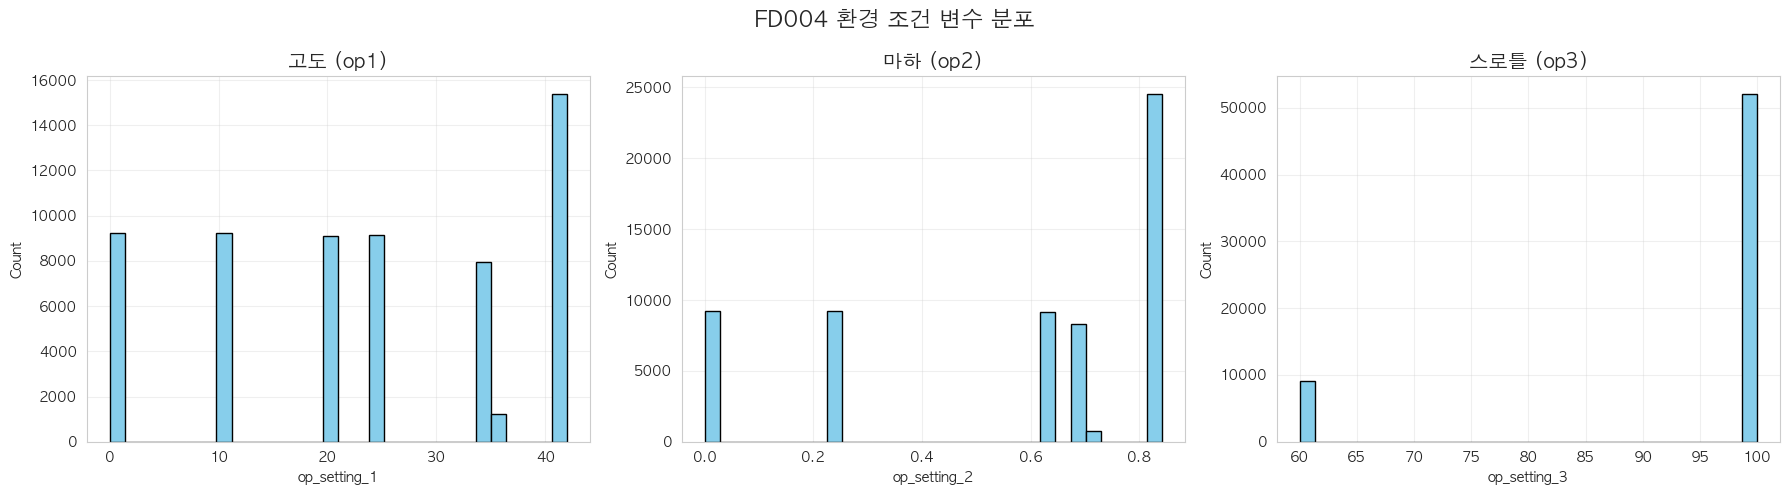

In [11]:
# FD004 환경 조건 변수 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
env_vars = ['op_setting_1', 'op_setting_2', 'op_setting_3']
titles = ['고도 (op1)', '마하 (op2)', '스로틀 (op3)']
for i, var in enumerate(env_vars):
    axes[i].hist(train_df[var], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].grid(alpha=0.3)
plt.suptitle('FD004 환경 조건 변수 분포', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- op1(고도) : 다중 이산 값  
0, 10, 20, 등의 특정 값들로 구성됨.  
연속적인 설정값이 아닌 단계별로 나뉘는 값.  
ex) 10 => 10,000 피트 고도 구간  
---
- op2(마하수) : 다중 이산 값  
0.0, 0.25, 0.6, 0.8 등 특정 값에 데이터가 분포  
연속적인 설정값이 아닌 단계별로 나뉘는 값.  
---
- op3(스로틀) : 이진 값  
60과 100, 단 2가지 추력 조건을 가짐  
이진 값으로 나타나는 특징이 보임.  
---
FD002, FD004는 6가지의 복합 운전 조건이 존재  
NASA 논문에 따르면, 고도, 마하수, 스로틀이 서로 다른 6가지의 조합을 나타냄  

## 3. 전체 사이클 분포 분석

각 엔진의 전체 수명 사이클 수를 파악하고, RUL을 계산합니다.

In [12]:
# 각 엔진별 전체 사이클 수 계산
train_max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
train_max_cycles.columns = ['unit_id', 'max_cycles']

print("엔진별 전체 사이클 수 통계:")
print(train_max_cycles['max_cycles'].describe())
print(f"\n총 엔진 수: {train_max_cycles['unit_id'].nunique()}개")
print(f"평균 수명: {train_max_cycles['max_cycles'].mean():.2f} cycles")
print(f"최소 수명: {train_max_cycles['max_cycles'].min()} cycles")
print(f"최대 수명: {train_max_cycles['max_cycles'].max()} cycles")

엔진별 전체 사이클 수 통계:
count    249.00000
mean     245.97992
std       73.11080
min      128.00000
25%      190.00000
50%      234.00000
75%      290.00000
max      543.00000
Name: max_cycles, dtype: float64

총 엔진 수: 249개
평균 수명: 245.98 cycles
최소 수명: 128 cycles
최대 수명: 543 cycles


<FD004_unit1>

In [13]:
sensor_cols = ['T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

sensor_stats = train_df[sensor_cols].agg(['mean', 'std', 'min', 'max']).T

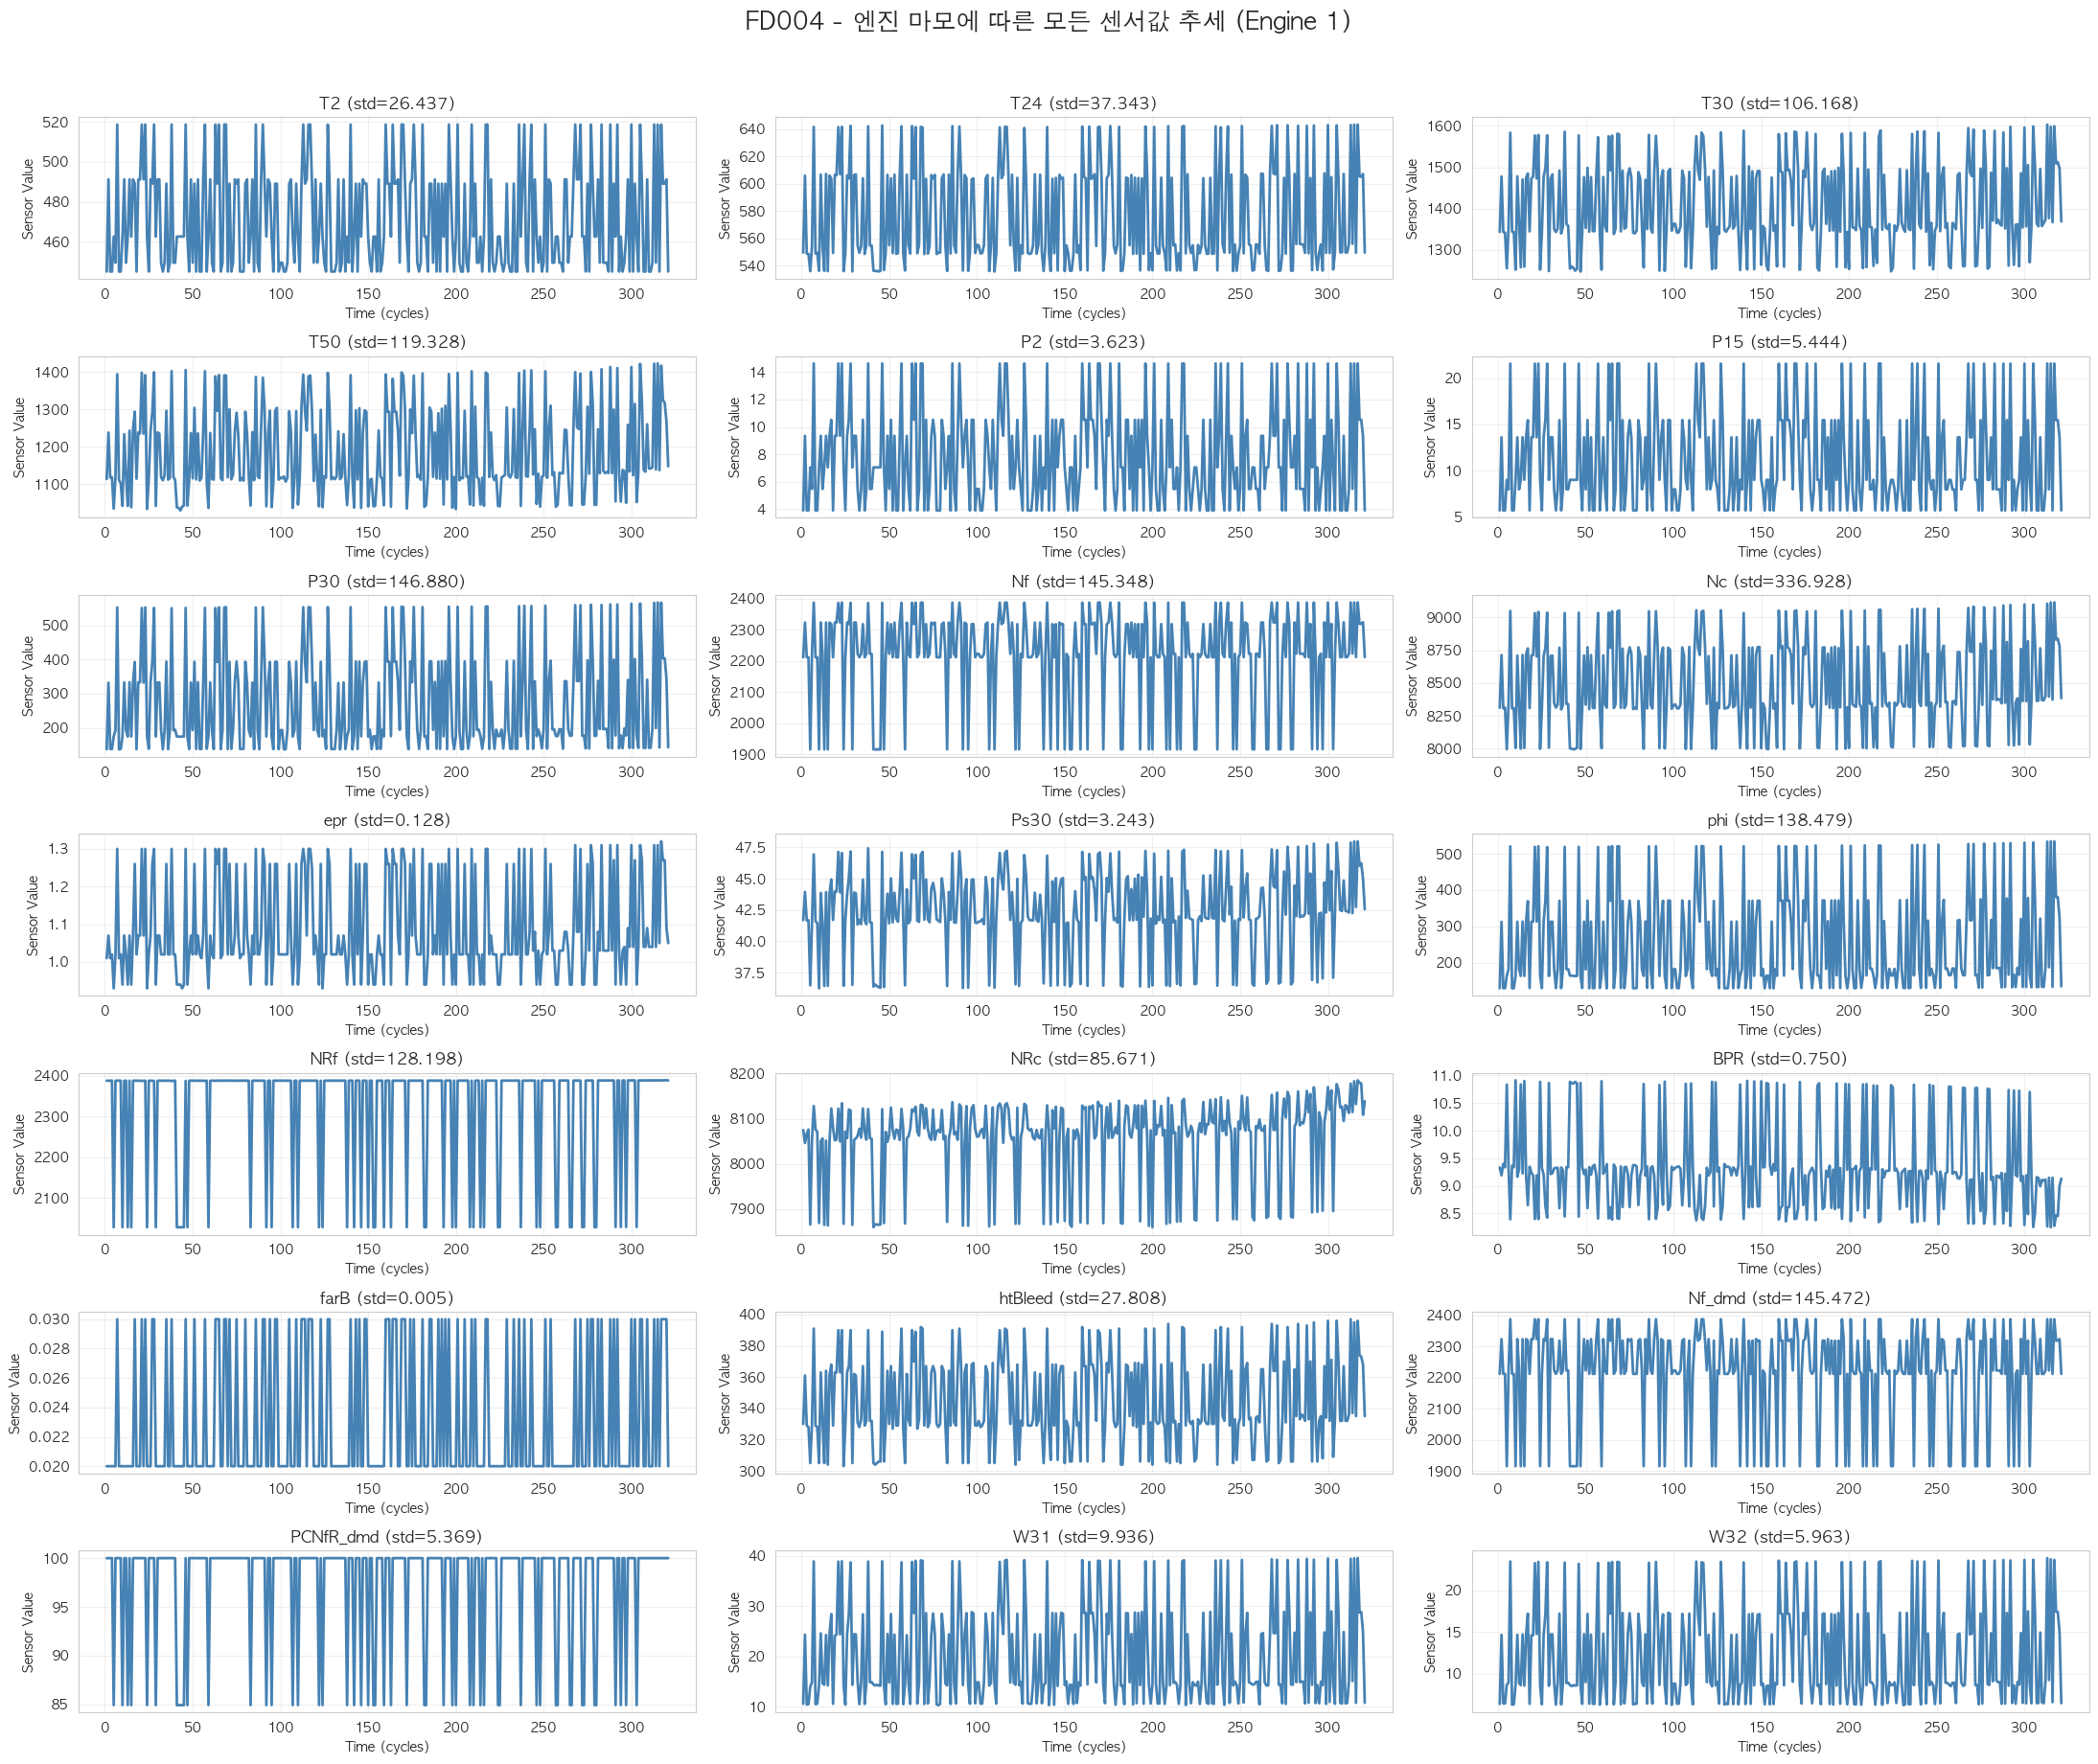

In [14]:
# 엔진 마모(사이클 진행)에 따른 모든 센서값 추세 시각화 (Engine 1, 21개 센서)
sample_engine = train_df[train_df['unit_id'] == 1].copy()
all_sensors = sensor_cols  # 21개 센서 모두
fig, axes = plt.subplots(7, 3, figsize=(22, 18))
axes = axes.ravel()
for idx, sensor in enumerate(all_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], color='steelblue', linewidth=2)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('Sensor Value', fontsize=10)
    axes[idx].grid(alpha=0.3)
# 빈 서브플롯 숨기기 (21개 이후)
for idx in range(len(all_sensors), len(axes)):
    axes[idx].axis('off')
plt.suptitle('FD004 - 엔진 마모에 따른 모든 센서값 추세 (Engine 1)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

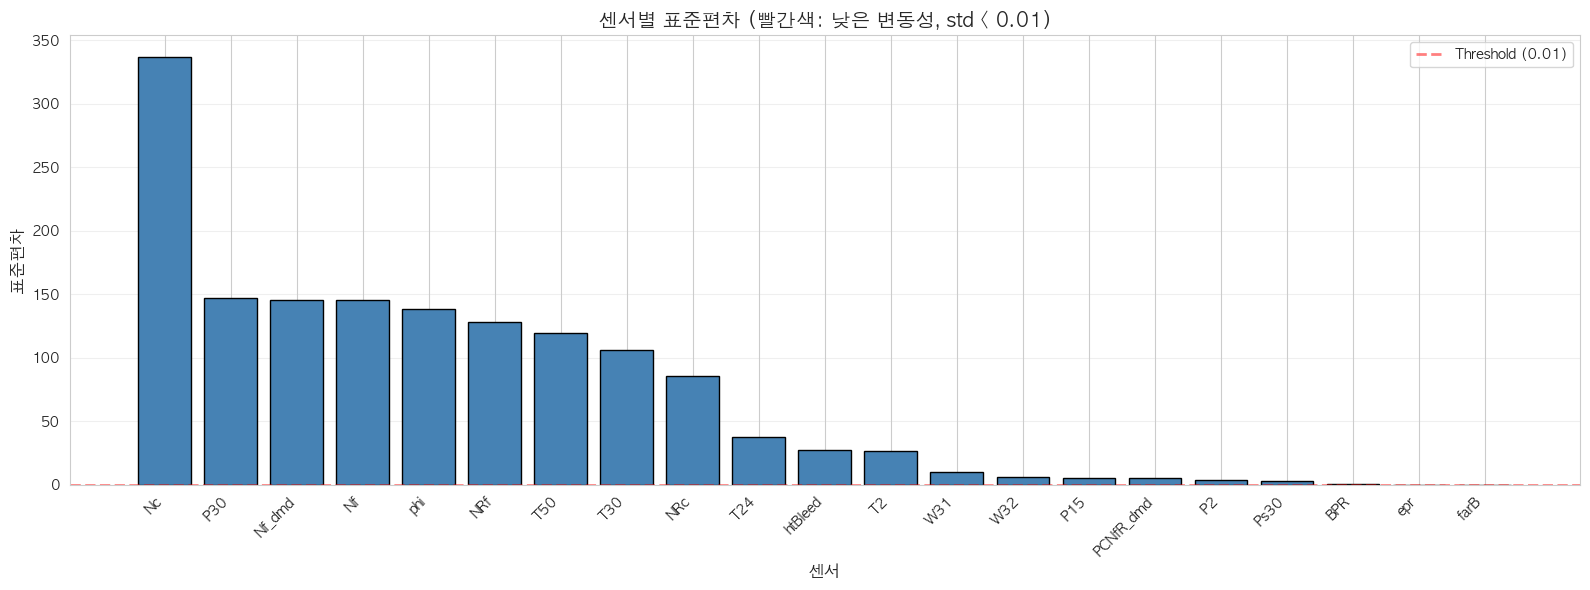

In [15]:
# 센서별 표준편차 시각화
fig, ax = plt.subplots(figsize=(16, 6))

sensor_stats_sorted = sensor_stats.sort_values('std', ascending=False)
colors = ['red' if x < 0.01 else 'steelblue' for x in sensor_stats_sorted['std']]

ax.bar(range(len(sensor_stats_sorted)), sensor_stats_sorted['std'], color=colors, edgecolor='black')
ax.set_xticks(range(len(sensor_stats_sorted)))
ax.set_xticklabels(sensor_stats_sorted.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('표준편차', fontsize=12)
ax.set_title('센서별 표준편차 (빨간색: 낮은 변동성, std < 0.01)', fontsize=14, fontweight='bold')
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.01)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Nc(코어 속도) 높은 편차를 보임.  
그 외 변수들 또한 운전 조건 변화에 의하여 편차가 발생.  

### RUL 적용

In [16]:
train_df['max_cycle'] = train_df.groupby('unit_id')['time_cycles'].transform('max')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop(columns='max_cycle', inplace=True)

train_df.to_csv('../CMaps/Data/train_FD004_with_RUL.csv', index=False)

In [17]:

rul_df = pd.read_csv('../CMaps/RUL_FD004.txt', header=None, names=['RUL'])

last_cycle_idx = test_df.groupby('unit_id')['time_cycles'].idxmax()
test_df['RUL'] = None 
test_df.loc[last_cycle_idx, 'RUL'] = rul_df['RUL'].values

test_df.to_csv('../CMaps/Data/test_FD004_with_RUL.csv', index=False)

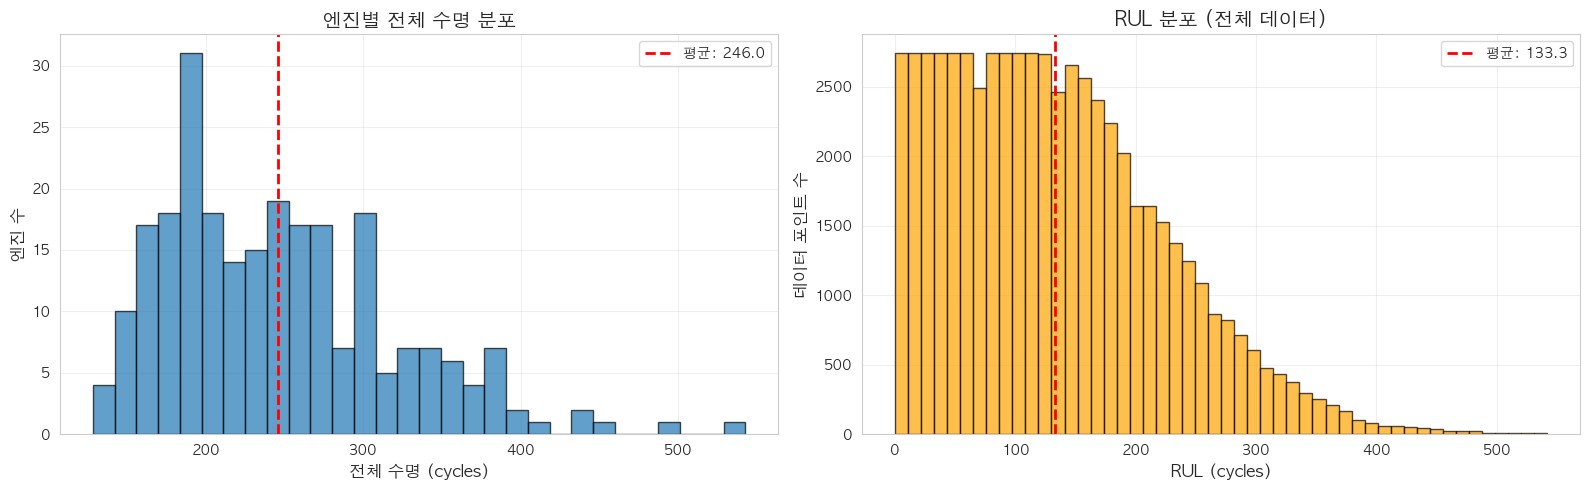

In [57]:
# 사이클 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. 엔진별 전체 사이클 수 히스토그램
axes[0].hist(train_max_cycles['max_cycles'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(train_max_cycles['max_cycles'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_max_cycles['max_cycles'].mean():.1f}")
axes[0].set_xlabel('전체 수명 (cycles)', fontsize=12)
axes[0].set_ylabel('엔진 수', fontsize=12)
axes[0].set_title('엔진별 전체 수명 분포', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. RUL 분포
axes[1].hist(train_df['RUL'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(train_df['RUL'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_df['RUL'].mean():.1f}")
axes[1].set_xlabel('RUL (cycles)', fontsize=12)
axes[1].set_ylabel('데이터 포인트 수', fontsize=12)
axes[1].set_title('RUL 분포 (전체 데이터)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 서로 다른 각각의 7개의 조건마다 센서의 변동성 확인

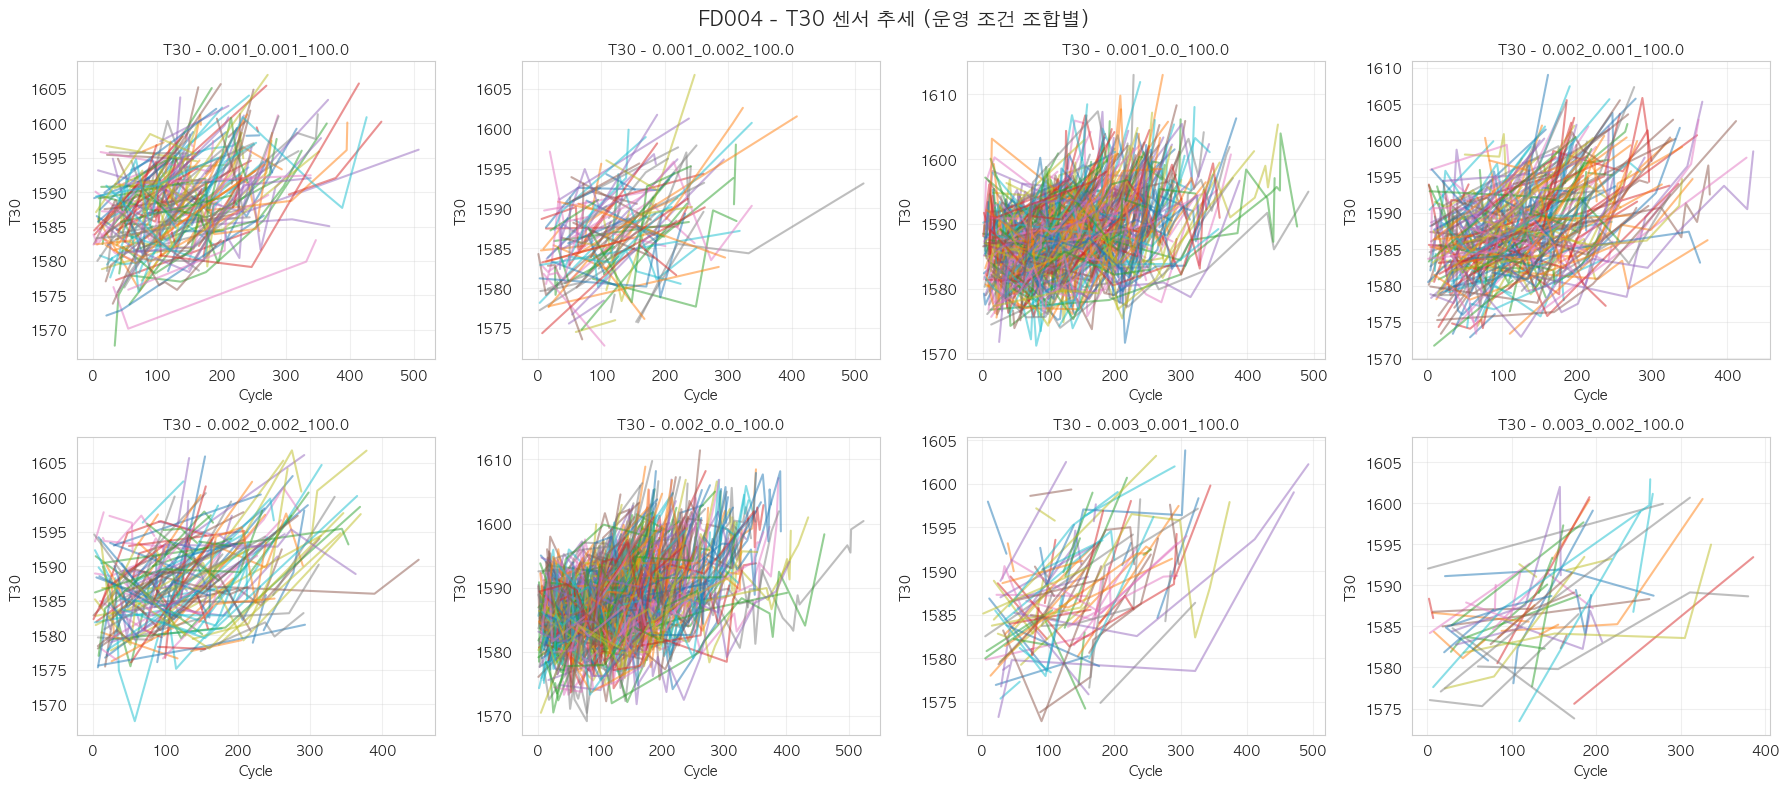

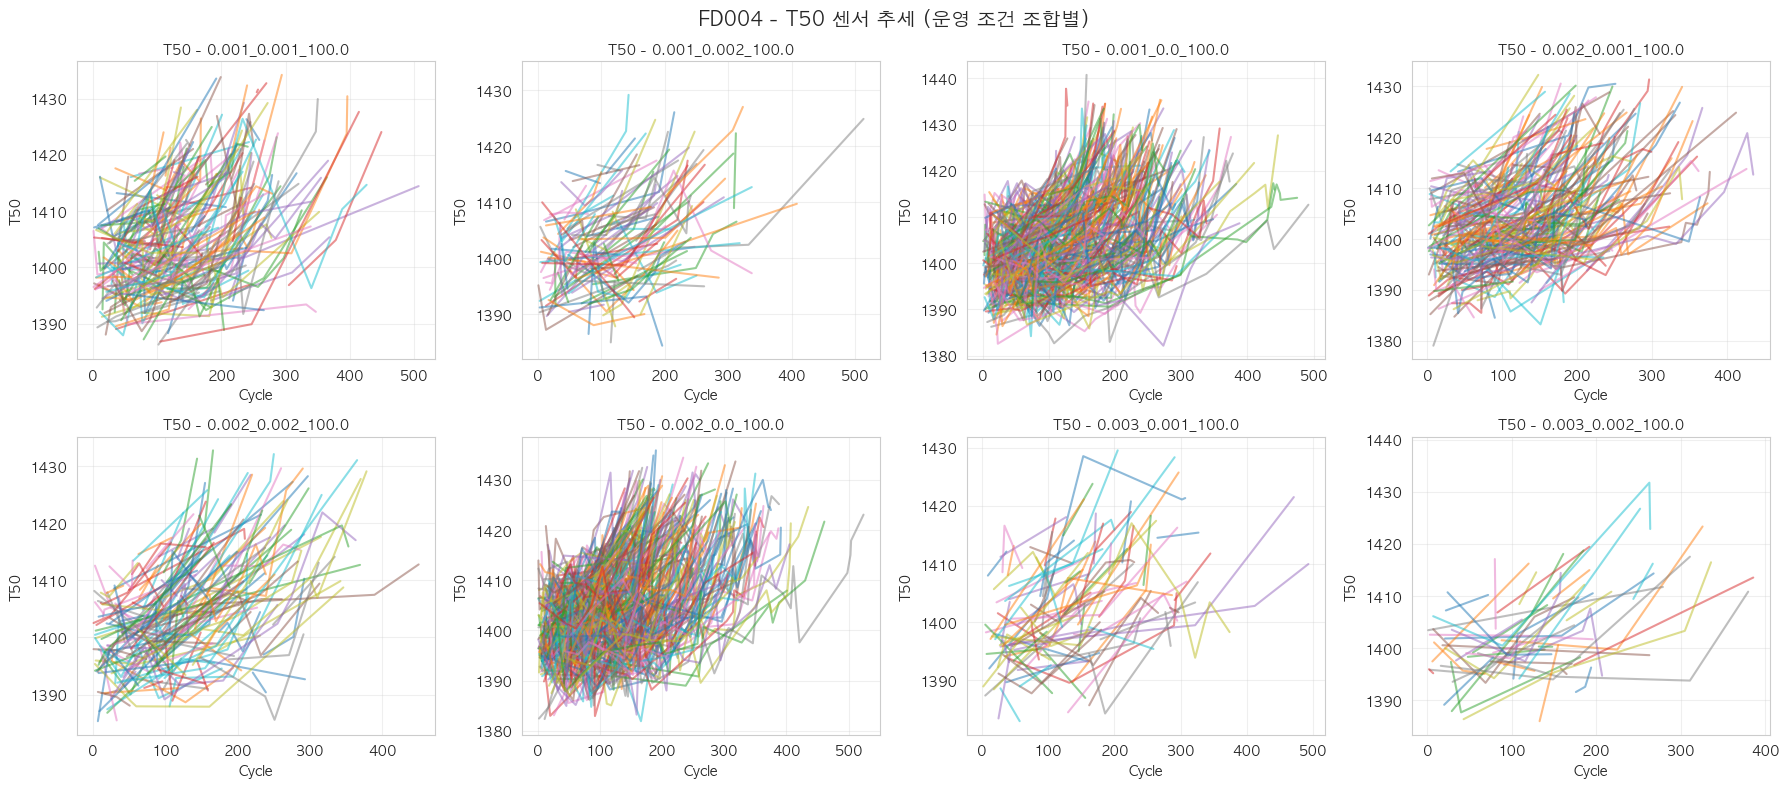

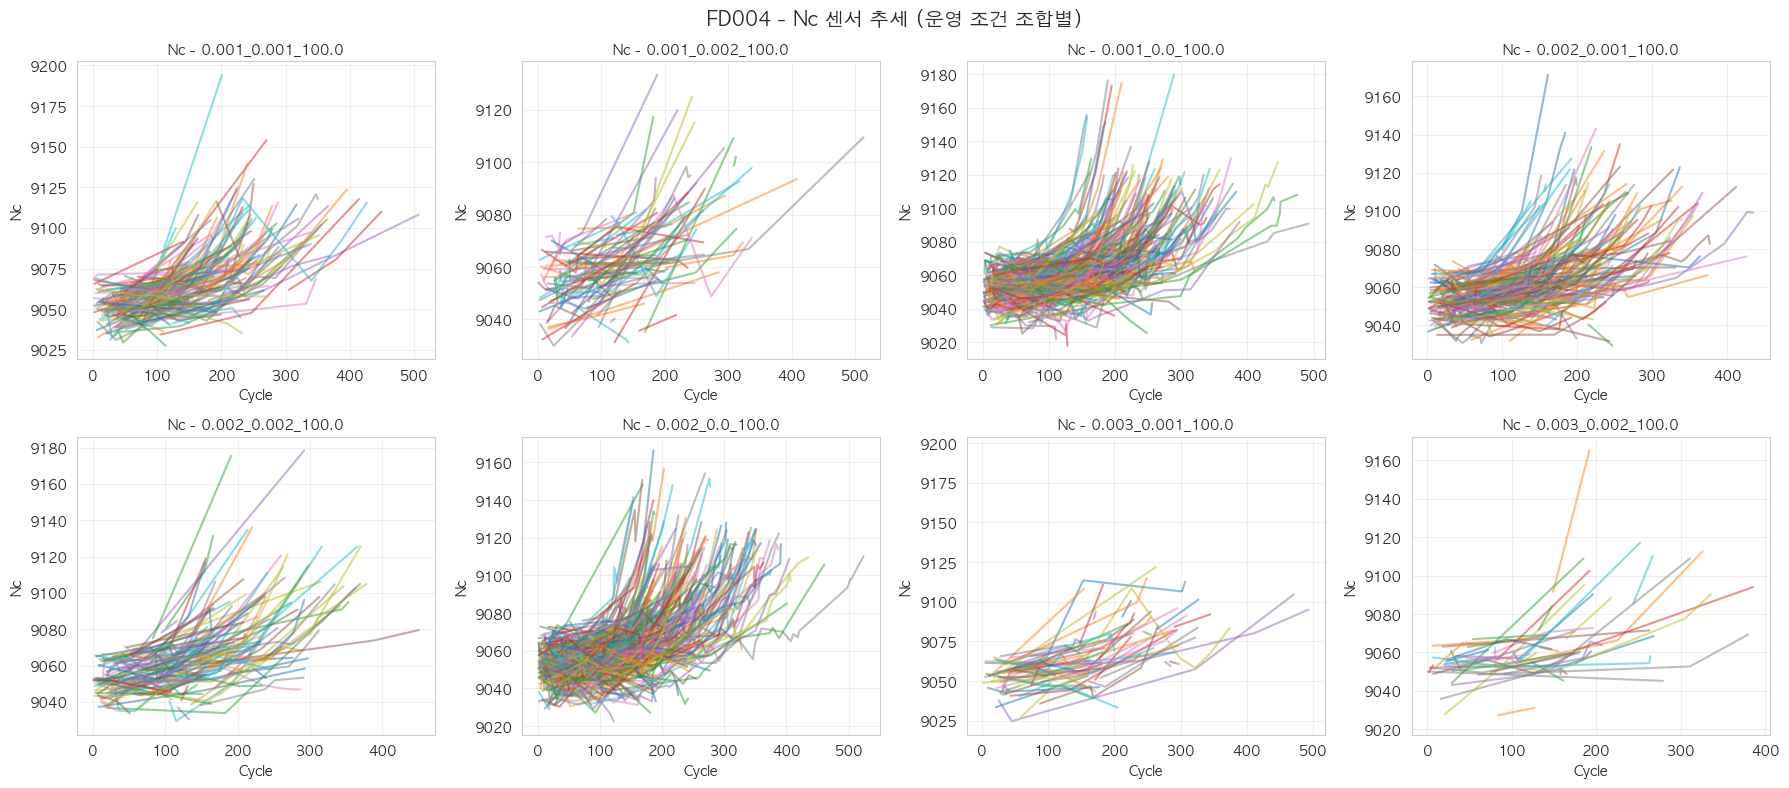

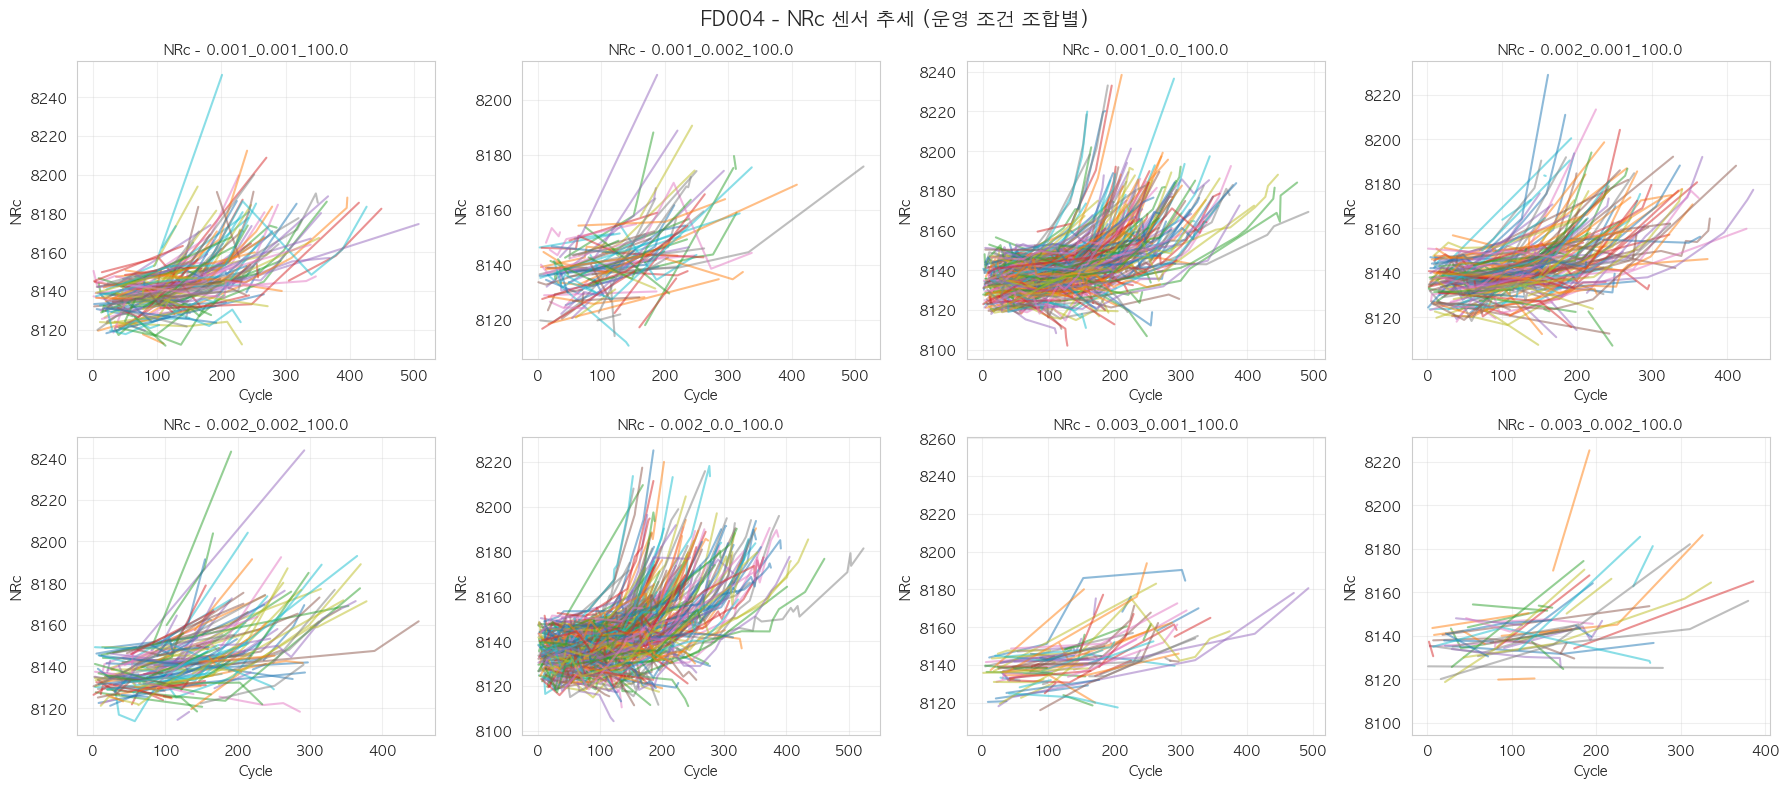

In [19]:
# 1. FD004 데이터 로드
column_names = [
    'unit_id', 'time_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]


# 2. 소수점 오차 방지 위해 반올림
train_df['setting_key'] = train_df[['op_setting_1', 'op_setting_2', 'op_setting_3']].round(3).astype(str).agg('_'.join, axis=1)
condition_groups = train_df.groupby('setting_key')

# 3. 시각화 대상 센서
sensor_cols = ['T30', 'T50', 'Nc', 'NRc']  

# 4. 각 조건 조합별로 센서 시계열 플롯 생성
for sensor in sensor_cols:
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.ravel()
    for i, (key, group) in enumerate(condition_groups):
        if i >= len(axes):
            break
        for unit in group['unit_id'].unique():
            unit_df = group[group['unit_id'] == unit]
            axes[i].plot(unit_df['time_cycles'], unit_df[sensor], alpha=0.5)
        axes[i].set_title(f'{sensor} - {key}', fontsize=10)
        axes[i].set_xlabel('Cycle')
        axes[i].set_ylabel(sensor)
        axes[i].grid(alpha=0.3)
    fig.suptitle(f'FD004 - {sensor} 센서 추세 (운영 조건 조합별)', fontsize=14)
    plt.tight_layout()
    plt.show()

## 4. 센서별 드리프트/패턴 분석

21개 센서 데이터의 특성을 분석합니다:
- 시간에 따른 변화 패턴
- 분산 및 변동성
- RUL과의 상관관계

In [60]:
print(f"\n낮은 변동성 센서 (std < 0.01): {low_variance_sensors}")


낮은 변동성 센서 (std < 0.01): ['farB']


RUL과의 상관계수 (절대값 기준 상위 10개):
NRc        0.078126
Ps30       0.056639
farB       0.053804
T50        0.045881
htBleed    0.032939
T30        0.032924
Nc         0.024727
epr        0.008924
T24        0.004443
BPR        0.003957
Name: RUL, dtype: float64


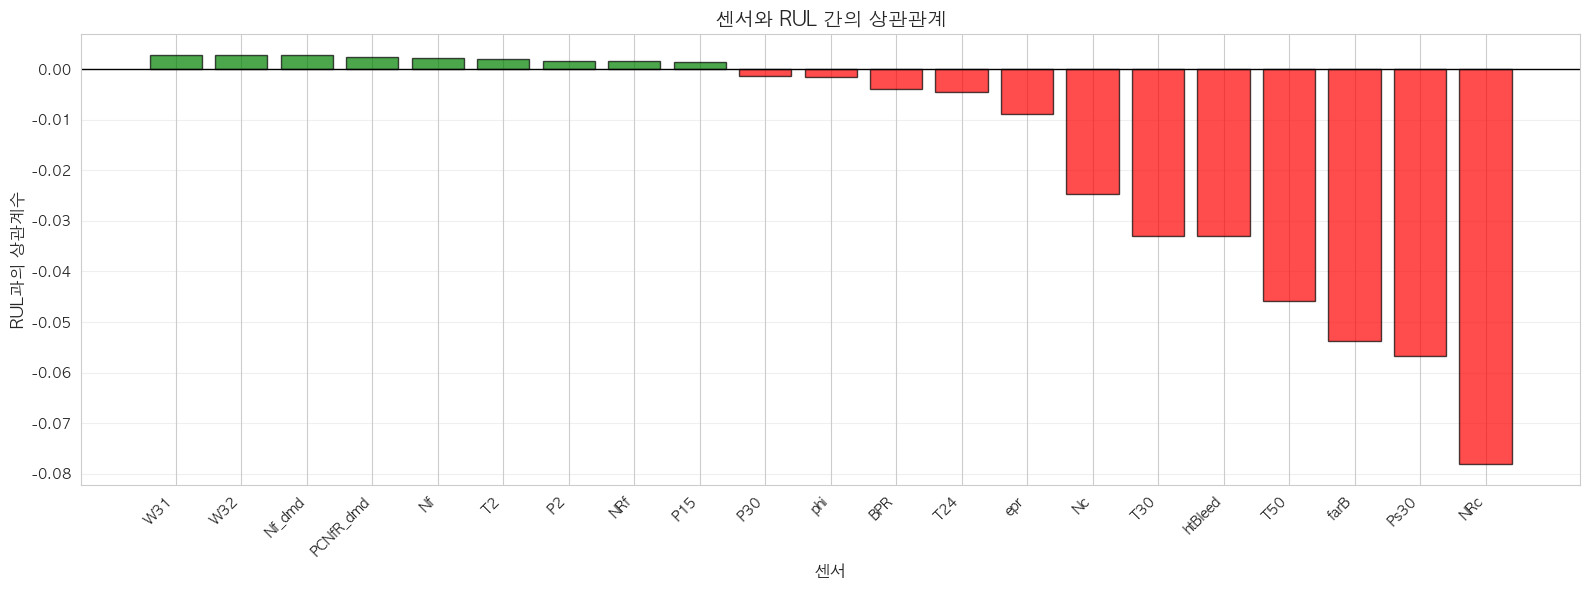

In [63]:
# RUL과 센서 간의 상관관계 분석
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

print("RUL과의 상관계수 (절대값 기준 상위 10개):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

# 상관계수 시각화
fig, ax = plt.subplots(figsize=(16, 6))

colors = ['green' if x > 0 else 'red' for x in correlation_with_rul.values]
ax.bar(range(len(correlation_with_rul)), correlation_with_rul.values, 
       color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(correlation_with_rul)))
ax.set_xticklabels(correlation_with_rul.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('RUL과의 상관계수', fontsize=12)
ax.set_title('센서와 RUL 간의 상관관계', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. 제거할 센서 리스트 확정

제거 기준:
1. **낮은 변동성**: 표준편차 < 0.01 (거의 상수값)
2. **낮은 상관성**: |상관계수| < 0.1 (RUL과의 관계가 약함)

In [ ]:
# 제거할 센서 식별
std_threshold = 0.01
corr_threshold = 0.03
# 1. 낮은 변동성 센서
low_variance = sensor_stats[sensor_stats['std'] < std_threshold].index.tolist()

# 2. 낮은 상관성 센서
low_correlation = correlation_with_rul[abs(correlation_with_rul) < corr_threshold].index.tolist()

# 합집합 (둘 중 하나라도 해당되면 제거 후보)
sensors_to_remove = list(set(low_variance + low_correlation))
sensors_to_remove.sort()

# 유지할 센서
sensors_to_keep = [s for s in sensor_cols if s not in sensors_to_remove]

print(f"\n1. 낮은 변동성 센서 (std < {std_threshold}):")
print(f"   {low_variance}")
print(f"\n2. 낮은 상관성 센서 (|corr| < {corr_threshold}):")
print(f"   {low_correlation}")
print(f"\n제거할 센서 (총 {len(sensors_to_remove)}개):")
print(f"   {sensors_to_remove}")
print(f"\n유지할 센서 (총 {len(sensors_to_keep)}개):")
print(f"   {sensors_to_keep}")


removal_info = pd.DataFrame({
    'sensor': sensors_to_remove,
    'std': [sensor_stats.loc[s, 'std'] for s in sensors_to_remove],
    'corr_with_RUL': [correlation_with_rul.loc[s] for s in sensors_to_remove],
    'reason': ['Low Variance' if s in low_variance else 'Low Correlation' 
               for s in sensors_to_remove]
})
print(removal_info.to_string(index=False))

센서 제거 분석 결과

1. 낮은 변동성 센서 (std < 0.01):
   ['farB']

2. 낮은 상관성 센서 (|corr| < 0.03):
   ['W31', 'W32', 'Nf_dmd', 'PCNfR_dmd', 'Nf', 'T2', 'P2', 'NRf', 'P15', 'P30', 'phi', 'BPR', 'T24', 'epr', 'Nc']

제거할 센서 (총 16개):
   ['BPR', 'NRf', 'Nc', 'Nf', 'Nf_dmd', 'P15', 'P2', 'P30', 'PCNfR_dmd', 'T2', 'T24', 'W31', 'W32', 'epr', 'farB', 'phi']

유지할 센서 (총 5개):
   ['T30', 'T50', 'Ps30', 'NRc', 'htBleed']

제거 센서 상세 정보
   sensor        std  corr_with_RUL          reason
      BPR   0.750374      -0.003957 Low Correlation
      NRf 128.197859       0.001501 Low Correlation
       Nc 336.927547      -0.024727 Low Correlation
       Nf 145.348243       0.002086 Low Correlation
   Nf_dmd 145.472491       0.002765 Low Correlation
      P15   5.444017       0.001349 Low Correlation
       P2   3.622872       0.001679 Low Correlation
      P30 146.880210      -0.001429 Low Correlation
PCNfR_dmd   5.369424       0.002303 Low Correlation
       T2  26.436832       0.001889 Low Correlation
      T24  37.34264

In [ ]:
# EDA 결과 저장 (추후 모델링에 활용)
eda_results = {
    'sensors_to_remove': sensors_to_remove,
    'sensors_to_keep': sensors_to_keep,
    'recommended_window_size': 15,
    'dataset_info': {
        'train_engines': train_df['unit_id'].nunique(),
        'test_engines': test_df['unit_id'].nunique(),
        'avg_lifetime': train_max_cycles['max_cycles'].mean(),
        'total_features': len(column_names)
    }
}

for key, value in eda_results.items():
    print(f"\n{key}:")
    print(f"  {value}")
    
print("\n✅ EDA 완료! 다음 단계로 Feature Engineering을 진행하세요.")

EDA 결과 저장 완료

sensors_to_remove:
  ['BPR', 'NRf', 'Nc', 'Nf', 'Nf_dmd', 'P15', 'P2', 'P30', 'PCNfR_dmd', 'T2', 'T24', 'W31', 'W32', 'epr', 'farB', 'phi']

sensors_to_keep:
  ['T30', 'T50', 'Ps30', 'NRc', 'htBleed']

recommended_window_size:
  15

dataset_info:
  {'train_engines': 249, 'test_engines': 248, 'avg_lifetime': 245.97991967871485, 'total_features': 26}

✅ EDA 완료! 다음 단계로 Feature Engineering을 진행하세요.
